In [1]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline

# Create a class to create pandas dataframe from SQL queries

In [3]:
#Read data from JDBC server
class DB:
    def __init__(self):
        self.tables = None
        self.df = None
        self.point = None
        self.POSTGRES_HOST = "codd03.research.northwestern.edu"
        self.POSTGRES_PORT = 5432
        self.POSTGRES_DBNAME = 'cpdb'
        self.POSTGRES_USERNAME = 'cpdb_student'
        self.POSTGRES_PASSWORD = 'DataSci4Lyfe'
        self.postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'.format(username=self.POSTGRES_USERNAME,
                                                                                           password=self.POSTGRES_PASSWORD,
                                                                                           host=self.POSTGRES_HOST,
                                                                                           port=self.POSTGRES_PORT,
                                                                                           dbname=self.POSTGRES_DBNAME))
        self.engine = create_engine(self.postgres_str)

    def query(self, queryCommand):
            self.point = self.engine.execute(queryCommand)
            self.df = None
            try: self.df = pd.DataFrame([*self.point.mappings()])
            except Exception as msg:
                if msg == 'This result object does not return rows. It has been closed automatically.':pass
            return self.df

    def get_tables_from_commands(self, commands=None):
        self.tables = {}
        for command in commands:
            try:
                df = self.query(command)
                if df is not None:
                    self.tables[f't{len(self.tables.keys())}'] = {'frame': df, 'sql': command}
            except:
                pass
        return self.tables



In [4]:
# test it out

def test():
    obj_test = DB()
    t = obj_test.get_tables_from_commands

    query1 = '''
    DROP TABLE if exists area_ids;
    CREATE TEMP TABLE area_ids AS
        ( SELECT id, name FROM data_area
          WHERE area_type='police-districts');
    SELECT * FROM area_ids;

    -- Determining civilian population of each PD
    DROP TABLE IF EXISTS popul_by_pd;
    CREATE TEMP TABLE popul_by_pd AS
        ( SELECT area_id, SUM("count") population FROM data_racepopulation
          WHERE area_id IN (SELECT id FROM area_ids)
          group by area_id);
    select * from popul_by_pd;
    '''

    commands = query1.split(';')
    tables = t(commands)
    if len(tables.keys()) == 2: print("Passed!")
    else: print("An error occurred")

    del obj_test

test()

Passed!


<br>

### Preprocessing helpers

In [5]:
def beat_to_side(df):
    pass



In [6]:
# keep columns which have more than 85% missing values
def remove_missing(df):
    columns = list(df1.columns)
    print(f"Originallly {len(columns)} columns")
    missing = pd.DataFrame(df1.isnull().sum())
    missing.reset_index(inplace=True)
    missing = missing.rename(columns = {'index':'columns', 0: 'null count'})
    missing["null count"] = missing["null count"].apply(lambda x: x*100/len(df1))
    remaining_columns = missing[missing["null count"] < 85.0]["columns"]
    print(f"Dropped to {len(remaining_columns)} columns")
    print(list(remaining_columns))
    return list(remaining_columns)

In [7]:
scalerST = preprocessing.StandardScaler()
scalerRB = preprocessing.RobustScaler()
scalers = [('std', scalerST), ('rb', scalerRB)]

### model selection helpers

In [8]:
# linear models

regrLinear = linear_model.LinearRegression()
regrRidge = linear_model.Ridge()
regrGamma = linear_model.GammaRegressor()
regrSGD = linear_model.SGDRegressor()



In [9]:
# kernal ridge
regrKernal = kernel_ridge.KernelRidge()


<br>

# Get all required tables

In [10]:
def table_from_file(filename):
    obj = DB()
    t = obj.get_tables_from_commands
    with open(filename, 'r') as f:
        sqlFile = f.read()
    commands_raw = sqlFile.split(';')
    commands = []
    for command in commands_raw:
        q = f'''
        {command}
        '''
        commands.append(q)
    tables = t(commands)
    total = len(tables.keys())
    print(total, "tables received")
    del obj
    return (total, tables)

# console0.sql
This is just used for converting beats to their respective city sides

In [11]:
filename = 'console0.sql'
_, table = table_from_file(filename)
table['t0']['frame'].head(2)

1 tables received


,name,side
0,3100,north
1,1655,north


In [12]:
temp_dict = table['t0']['frame'].to_dict('records')
conversion_dict = {}
for t in temp_dict:
    if t['name'] not in conversion_dict.keys():
        conversion_dict[t['name']] = t['side']

In [13]:
conversion_dict

{3100: 'north',
 1655: 'north',
 1613: 'north',
 1611: 'north',
 1621: 'north',
 1654: 'north',
 1622: 'north',
 1614: 'north',
 1712: 'north',
 1711: 'north',
 1834: 'north',
 2211: 'north',
 1722: 'north',
 1121: 'north',
 1112: 'north',
 1814: 'north',
 1212: 'north',
 1913: 'north',
 1914: 'north',
 1915: 'north',
 1833: 'north',
 1922: 'north',
 1713: 'north',
 1651: 'north',
 1912: 'north',
 1723: 'north',
 1832: 'north',
 1732: 'north',
 1911: 'north',
 1724: 'north',
 2024: 'north',
 1624: 'north',
 1211: 'north',
 1632: 'north',
 1925: 'north',
 2422: 'north',
 1731: 'north',
 1921: 'north',
 1653: 'north',
 1733: 'north',
 1652: 'north',
 1634: 'north',
 2424: 'north',
 1633: 'north',
 1924: 'north',
 1631: 'north',
 1934: 'north',
 1933: 'north',
 2423: 'north',
 2431: 'north',
 2411: 'north',
 2033: 'north',
 2032: 'north',
 2022: 'north',
 2412: 'north',
 2023: 'north',
 1612: 'north',
 2413: 'north',
 2013: 'north',
 2433: 'north',
 114: 'south',
 111: 'south',
 222: 'sou

# console1.sql

In [14]:
filename = 'console1.sql'
total, tables = table_from_file(filename)

3 tables received


### Data visualization

In [15]:
df0 = tables['t0']['frame']
q0 = ' '.join(tables['t0']['sql'].split('\n'))
print(q0)
df0.to_csv('tables\\df0.csv')

          select * from trr_count_by_year_side         


In [16]:
df1 = tables['t1']['frame']
q1 = ' '.join(tables['t1']['sql'].split('\n'))
print(q1)
df1.to_csv('tables\\df1.csv')

          select * from trr_count_by_year         


In [17]:
df2 = tables['t2']['frame']
q2 = ' '.join(tables['t2']['sql'].split('\n'))
print(q2)
df2.to_csv('tables\\df2.csv')

          select * from trr_count_by_year_beats         


In [18]:
df0 = pd.read_csv("tables\\df0.csv").sort_values(by="years")

In [19]:
df1 = pd.read_csv("tables\\df1.csv").sort_values(by="years")

In [20]:
df2 = pd.read_csv("tables\\df2.csv").sort_values(by="years")

**What is TRR?**
TRR is the abbreviation for *Tactical Response Reports*. Usually an event has one complaint with a unique id (CRID) linked to it. But in cases when an event has one or more use of force reports linked to it, it comes under TRR data.

Let's check out the trr counts from each year. First we'll look at overall trr count yearly, and then we will visualize the trr count by year distinguished by north and south sides.

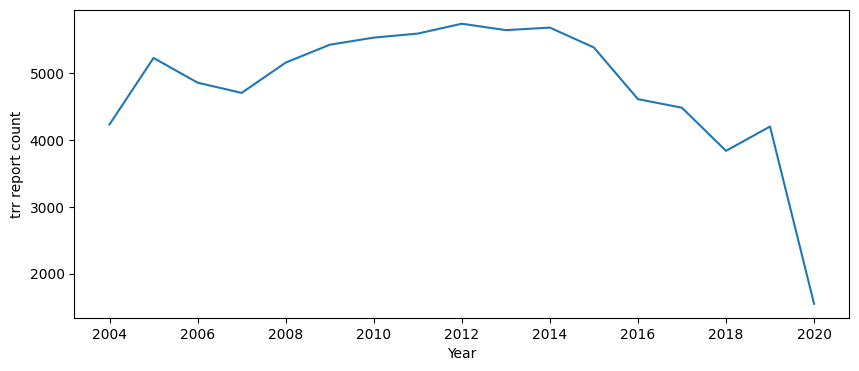

In [21]:
count = list(df1["count"])
years = list(df1["years"])

plt.figure(figsize=(10,4))
plt.plot(years, count)
plt.xlabel("Year")
plt.ylabel("trr report count")
# plt.xticks(np.arange(len(years)), list(years))
plt.show()

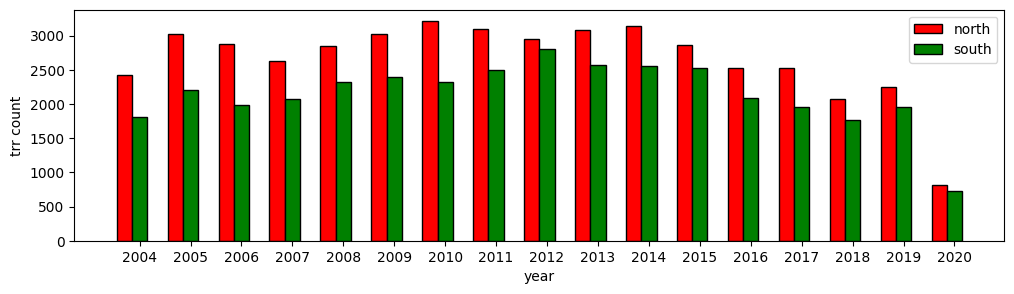

In [22]:
def barNS(df,years):
    barwidth = 0.3

    # years = df[df["side"]=='north']["years"] # same for south
    countNorth = df[df["side"]=='north']["count"]
    countSouth = df[df["side"]=='south']["count"]

    r1 = np.arange(len(countNorth))
    r2 = [x + barwidth for x in r1]

    fig = plt.subplots(figsize=(12, 3))
    plt.bar(r1, countNorth, width=barwidth, color='r', edgecolor="black", label="north")
    plt.bar(r2, countSouth, width=barwidth, color='g', edgecolor="black", label="south")
    plt.xlabel("year")
    plt.ylabel("trr count")
    plt.xticks([r + barwidth for r in range(len(countNorth))], years)
    plt.legend()
    plt.show()


barNS(df0, years)

**Observation:**
It is interesting to note that in all cases multiple cases of complaint reports related to a single event comes usually from the north side. Overall, 2020 has far fewer trr reports. These could be because the data for 2020 is more recent and possibly lacking.

**Question** : *Can we use this information to create a reliable model that can predict the trr count per year?*

 We are going to use df2 for this part, which contains all the beat names and is categorized according to trr count per year per beat. We are going to define our goal first.

### **GOAL** : Predict the yearly trr count by city side.


**Question:** *Why are we using df2?* 

df0 only concerns with two columns : city side and trr count. This is a very small dataset and therefore not reliable enough to train our model. df2 however, is concerned with more detail- the beats. Therefore, this is more reliable to train our model. 

In [23]:
df2.head(3).drop(columns=['Unnamed: 0'])

,beat,count,years
0,1923,7,2004
2957,1922,3,2004
2966,211,7,2004


In [24]:
y = np.array(df2["count"])
X = np.array(df2[['beat', 'years']])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(len(X_train), '\n', len(X_test))

3540 
 885


Checking out a very simple model first! We are only using standard scaler followed by linear regression

In [25]:
X_tf = scalerST.fit_transform(X_train)
regrLinear.fit(X_tf, y_train)
metrics.r2_score(y_test, regrLinear.predict(X_test))


-148452.24208714397

This simple model performs VERY poorly. Can we improve?

In [26]:
random.seed(10)

pipelines = []
models = [('lreg', regrLinear), ('rreg', regrRidge), ('greg', regrGamma), ('sgdreg', regrSGD), ('kreg', regrKernal)]
results1 = {"model" : [], "best hparams": [], "best score": []}
scaling_union = ('scaler', pipeline.FeatureUnion(scalers))
params = [{'lreg__positive': [True, False]},
          {'rreg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'rreg__positive': [True, False]},
          {'greg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'greg__warm_start': [True, False]},
          {'sgdreg__penalty': ['l2', 'l1', 'elasticnet'], 'sgdreg__learning_rate': ['optimal', 'invscaling', 'adaptive'], 'sgdreg__max_iter': [10000]},
          {'kreg__alpha': [0.00005, 0.0001, 0.0005, 0.001, 0.005], 'kreg__kernel': ["rbf"]}]


for i in range(len(models)):
    results1["model"].append(models[i][1])
    reg = pipeline.Pipeline([scaling_union, models[i]])
    grids = model_selection.GridSearchCV(reg, param_grid=params[i], cv=5)
    grids.fit(X_train, y_train)
    best_estimator = grids.best_estimator_
    pipelines.append(best_estimator)
    best_estimator.fit(X_train, y_train)
    score = metrics.r2_score(y_test, best_estimator.predict(X_test))
    results1["best score"].append(score)
    results1["best hparams"].append(grids.best_params_)

resultdf = pd.DataFrame(results1)
resultdf.to_csv('results\\result1.csv')
resultdf

,model,best hparams,best score
0,LinearRegression(),{'lreg__positive': False},0.032423
1,Ridge(),"{'rreg__alpha': 1, 'rreg__positive': False}",0.030092
2,GammaRegressor(),"{'greg__alpha': 0.05, 'greg__warm_start': True}",0.026706
3,SGDRegressor(),"{'sgdreg__learning_rate': 'invscaling', 'sgdre...",0.031209
4,KernelRidge(),"{'kreg__alpha': 5e-05, 'kreg__kernel': 'rbf'}",0.151849


A little better than what we had before. But we want to generalize this to our goal? We are gonna look at the best model out of the 5 we have right now, and see how it fares when we are just trying to predict trr count yearly by side instead of by beat.

In [27]:
pipelines[4] # current best

Pipeline(steps=[('scaler',
                 FeatureUnion(transformer_list=[('std', StandardScaler()),
                                                ('rb', RobustScaler())])),
                ('kreg', KernelRidge(alpha=5e-05, kernel='rbf'))])

In [28]:
clf = pipelines[4]

y_pred = pd.DataFrame(clf.predict(X_test)).rename(columns = {0: 'count'})
y_testdf = pd.DataFrame(y_test).rename(columns = {0: 'count'})

X_testdf = pd.DataFrame(X_test).rename(columns={0: 'side', 1: 'years'})
X_testdf["side"] = X_testdf["side"].apply(lambda x: conversion_dict[x])

df_pred = pd.concat([X_testdf, y_pred], axis=1, join='inner')
df_actual = pd.concat([X_testdf, y_testdf], axis=1, join='inner')

temp_pred = df_pred.groupby(['side', 'years']).agg({'count': ['sum']})
temp_actual = df_actual.groupby(['side', 'years']).agg({'count': ['sum']})

temp_pred.columns = ['sum']
temp_actual.columns = ['sum']

df_pred = temp_pred.reset_index().rename(columns={'sum':'count'})
df_actual = temp_actual.reset_index().rename(columns={'sum':'count'})

Predicted trr report counts per year for beats included in test data using Kernal Ridge


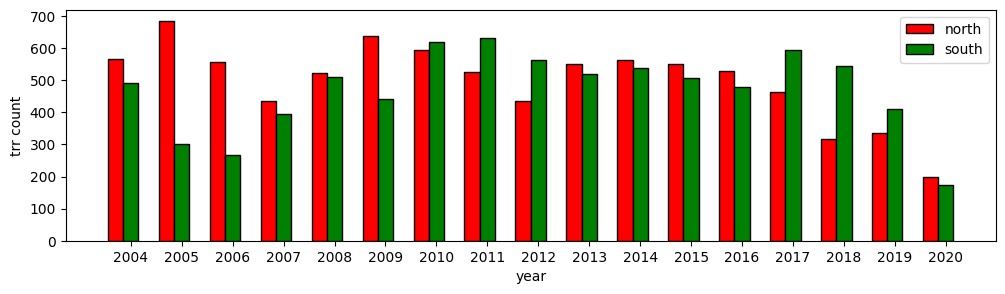

In [29]:
print("Predicted trr report counts per year for beats included in test data using Kernal Ridge")
barNS(df_pred, years)

Actual trr counts per year for beats included in test data


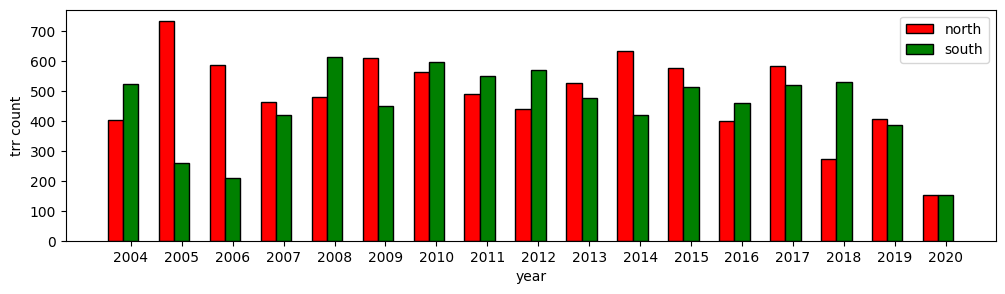

In [30]:
print("Actual trr counts per year for beats included in test data")
barNS(df_actual, years)

In [31]:
metrics.r2_score(df_pred['count'], df_actual['count'])

0.7422694694278559

<br>

### Question

How can we improve now?

Let us use a bit more information, such as the officer history of the officers involved in the trr incidents. We are going to now perform a few more sql queries for that.